# Classification for bank churn

In this notebook we will use BlueCastCV for the churn dataset. This is a convenience wrapper which calls 5 BlueCast models by default. This notebook will have some differences:

* no eval dataset split (this is done by BlueCast automatically)
* we use all data for training as the individual models will all use different splits (none has seen all data, but among all models each data point has been seen at least once)
* we have one pipeline for all models, but lots of information is printed for us

The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression
from bluecast.evaluation.eval_metrics import ClassificationEvalWrapper

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [4]:
train

id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       33.0       3       0.00              2        1.0             0.0   
1       33.0       1       0.00              2        1.0             1.0   
2       40.0      10       0.00              2        1.0             0.0   
3       34.0       2  148882.54              1        1.0             1.0   
4       33.0       5       0.00              2        1.0             1.0   
...      ...     ...        ...            ...        ...             ...   
165029  33.0       2       0.00              1        1.0             1.0   
165030  35.0       3       0.00              1        0.0             0.0   
165031  31.0       5       0.00              1        1.0             1.0   
165032  30.0       7  161533.00              1        0.0             1.0   
165033  31.0       1       0.00              1        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
165029        131834.75       0  
165030        131834.45       0  
165031        127429.56       0  
165032         71173.03       0  
165033         61581.79       1  

[165034 rows x 14 columns]

# Define constants

In [5]:
TARGET = "Exited"

# Apply learnings from EDA

In [6]:
to_drop = [] # ["id", "CustomerId", "Surname"]

train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# Add feature engineering

To show some more competitive score we take some feature engineering from a top notebook: 
Feature engineering taken from: https://www.kaggle.com/code/aspillai/11th-place-solution-single-model-cv-cat

The feature engineering is Kaggle-specific and takes data from the test set, which would be unseen data in real world applications.

In [7]:
df_all = pd.concat([train, test]).reset_index(drop=True)

aggs = {
    'Age': ['min','max', 'mean'],       
    'Balance': ['min','max', 'mean'],
    'NumOfProducts': ['mean','sum'],
    'IsActiveMember': ['min','max', 'mean','sum'],
    'CreditScore': ['min','max', 'mean'],
    'EstimatedSalary': ['min','max', 'mean'],
    'id': 'count',
}

df_grps = df_all.groupby(['CustomerId', 'Surname', 'Geography', 'Gender']).agg(aggs).reset_index()
df_grps.columns = list(map(''.join, df_grps.columns.values))
df_grps

CustomerId       Surname Geography  Gender  Agemin  Agemax  Agemean  \
0         15565701         Bruno     Spain    Male    49.0    49.0     49.0   
1         15565701       Chineze    France    Male    32.0    32.0     32.0   
2         15565701         Ferri    France  Female    39.0    39.0     39.0   
3         15565701         Ferri     Spain    Male    34.0    34.0     34.0   
4         15565706      Akobundu    France    Male    37.0    40.0     38.5   
...            ...           ...       ...     ...     ...     ...      ...   
235253    15815690  Onyemachukwu    France    Male    41.0    41.0     41.0   
235254    15815690          Teng    France    Male    42.0    42.0     42.0   
235255    15815690         Tseng     Spain    Male    35.0    35.0     35.0   
235256    15815690          Tuan   Germany  Female    33.0    33.0     33.0   
235257    15815690       Yobanna    France  Female    36.0    36.0     36.0   

        Balancemin  Balancemax  Balancemean  ...  IsActiveMembermax  \
0             0.00        0.00         0.00  ...                1.0   
1        107209.58   107209.58    107209.58  ...                1.0   
2        161993.89   161993.89    161993.89  ...                0.0   
3        161993.89   161993.89    161993.89  ...                0.0   
4             0.00        0.00         0.00  ...                1.0   
...            ...         ...          ...  ...                ...   
235253        0.00        0.00         0.00  ...                0.0   
235254        0.00        0.00         0.00  ...                1.0   
235255   135277.96   135277.96    135277.96  ...                0.0   
235256   144591.96   144591.96    144591.96  ...                1.0   
235257        0.00        0.00         0.00  ...                1.0   

        IsActiveMembermean  IsActiveMembersum  CreditScoremin  CreditScoremax  \
0                      1.0                1.0             846             846   
1                      1.0                1.0             705             705   
2                      0.0                0.0             698             698   
3                      0.0                0.0             707             707   
4                      0.5                1.0             612             682   
...                    ...                ...             ...             ...   
235253                 0.0                0.0             590             590   
235254                 1.0                1.0             565             565   
235255                 0.0                0.0             727             727   
235256                 1.0                1.0             651             651   
235257                 1.0                1.0             582             582   

        CreditScoremean  EstimatedSalarymin  EstimatedSalarymax  \
0                 846.0            90280.70            90280.70   
1                 705.0           129822.79           129822.79   
2                 698.0            90212.38            90212.38   
3                 707.0            94912.78            94912.78   
4                 647.0            83256.26            83256.26   
...                 ...                 ...                 ...   
235253            590.0           156791.24           156791.24   
235254            565.0            83473.82            83473.82   
235255            727.0           126342.84           126342.84   
235256            651.0           139469.11           139469.11   
235257            582.0            85985.88            85985.88   

        EstimatedSalarymean  idcount  
0                  90280.70        1  
1                 129822.79        1  
2                  90212.38        1  
3                  94912.78        1  
4                  83256.26        2  
...                     ...      ...  
235253            156791.24        1  
235254             83473.82        1  
235255            126342.84        1  
235256            139469.11        1  

In [8]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    df = df.merge(df_grps,how='left',on=['CustomerId', 'Surname', 'Geography', 'Gender'])
    return df

train = getFeats(train)
test = getFeats(test)

# Creating the pipeline

In this section we create the pipeline for our base model.

In [9]:
wrapper = ClassificationEvalWrapper(
        eval_against="probas_target_class", metric_func=roc_auc_score, higher_is_better=True
    )

automl_baseline = BlueCastCV(class_problem="binary", single_fold_eval_metric_func=wrapper)

automl_baseline.conf_training.hypertuning_cv_folds = 1
automl_baseline.conf_training.train_size = 0.9
automl_baseline.conf_xgboost.xgboost_eval_metric = "auc" # applicable for > 1-fold training

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:root:Start fitting model number 0 with random seed 233
2024-08-25 22:03:01,191 - root - INFO - BlueCast blueprint initialized.
2024-08-25 22:03:01,191 - root - INFO - Start detecting and casting feature types.
2024-08-25 22:03:01,221 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 22:03:01,221 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 22:03:01,284 - root - INFO - Dropped the following columns as constants only: [].
2024-08-25 22:03:01,285 - root - INFO - Dropped the following columns as constants only: [].
2024-08-25 22:03:02,843 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is d

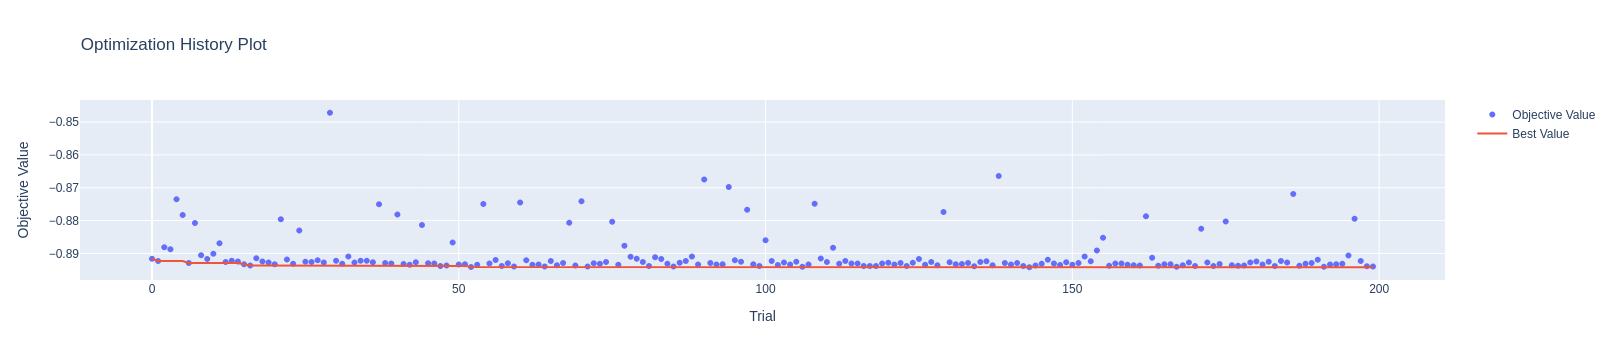

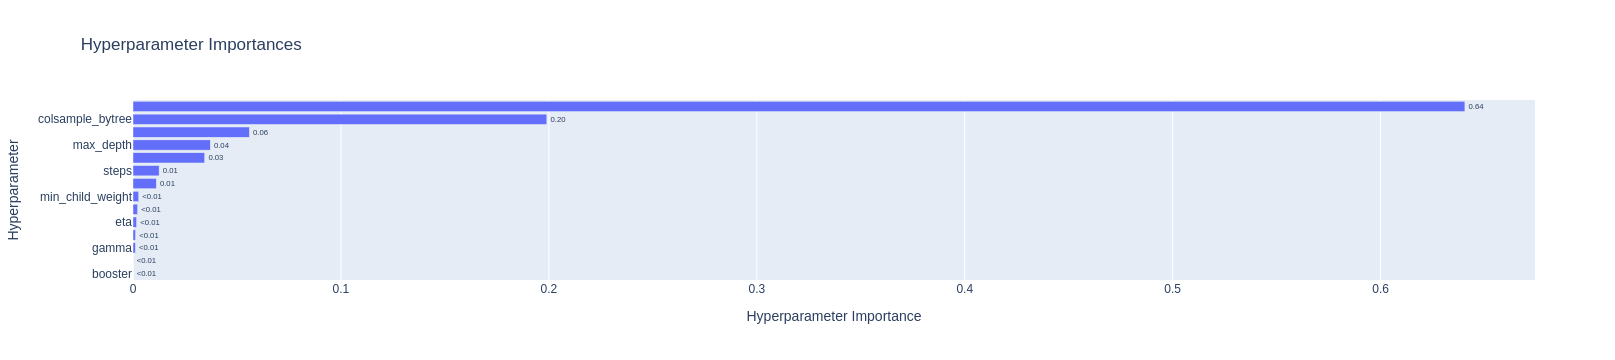

2024-08-25 22:30:58,129 - root - INFO - New best score: -0.8942110383936923 from random seed  233
2024-08-25 22:30:58,130 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 7, 'alpha': 0.5065872614891997, 'lambda': 21.47548662767484, 'gamma': 1.206776955338705e-07, 'min_child_weight': 4.281064735176769, 'subsample': 1.0, 'colsample_bytree': 0.3757147370533712, 'colsample_bylevel': 0.7405084662370605, 'eta': 0.06149906221343179, 'steps': 684, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 138}
2024-08-25 22:30:58,131 - root - INFO - Start final model training
2024-08-25 22:30:58,131 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 7, 'alpha': 0.5065872614891997, 'lambda': 21.47548662767484, 'gamma': 1.206776955338705e-07, 'min_child_weight': 4.281064735176769, 'subsample': 1.0, 'colsample_bytree': 0.3757147370533712, 'colsample_bylevel': 0.7405084662370605, 'eta': 0.06149906221343179, 'steps': 684, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 138}
Finished hyperparameter tuning


2024-08-25 22:31:30,680 - root - INFO - Finished training


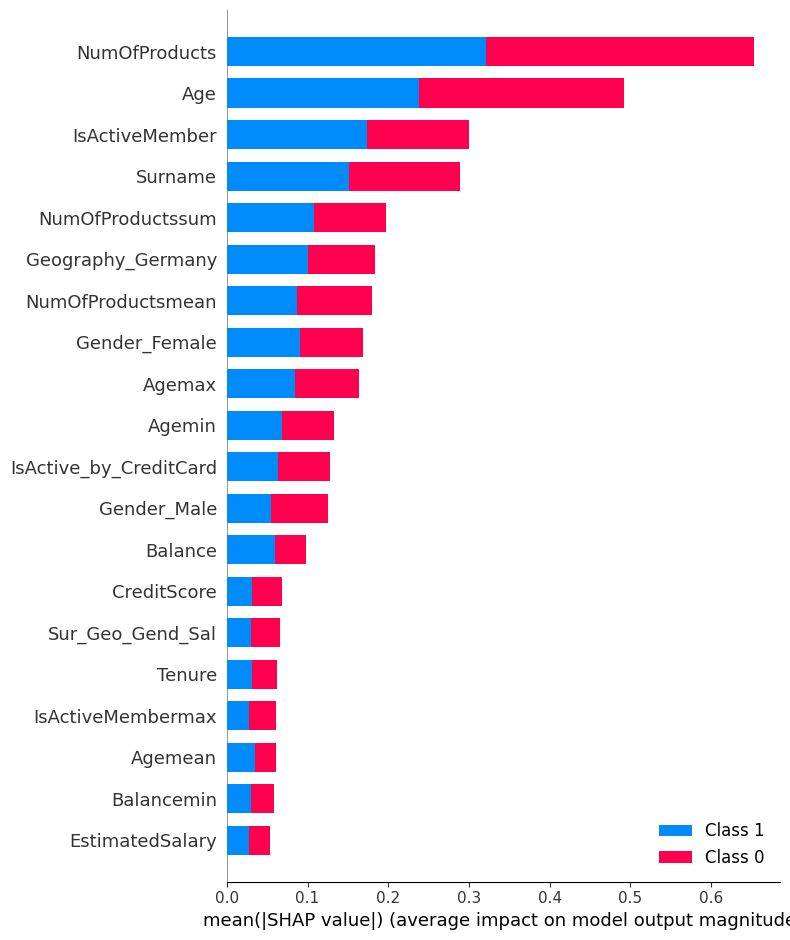

2024-08-25 22:33:13,297 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-25 22:33:13,304 - root - INFO - Start casting feature types.
2024-08-25 22:33:13,306 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 22:33:13,307 - root - INFO - Dropped the following columns as constants only: [].
2024-08-25 22:33:13,309 - root - INFO - Start filling infinite values.
2024-08-25 22:33:13,321 - root - INFO - Start date column conversion.
2024-08-25 22:33:13,321 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-25 22:33:13,324 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 22:33:13,338 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 22:33:13,353 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 22:33:13,365 - root - INFO - Predicting...
2024-08-25 22:33:13

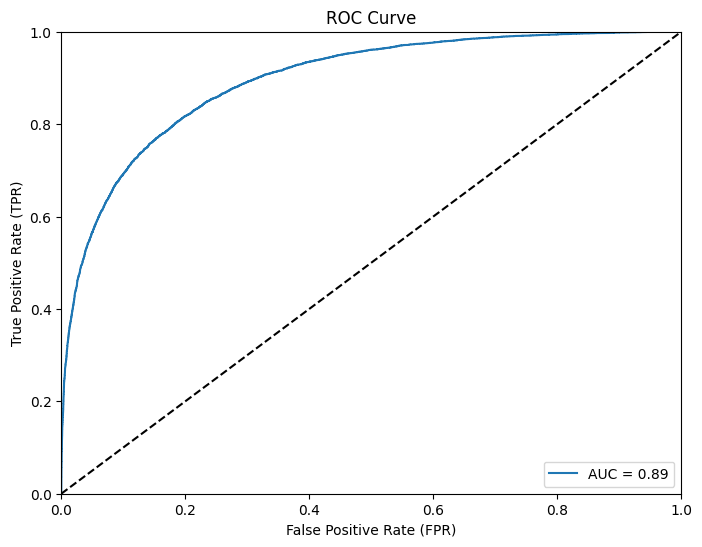

2024-08-25 22:33:13,616 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


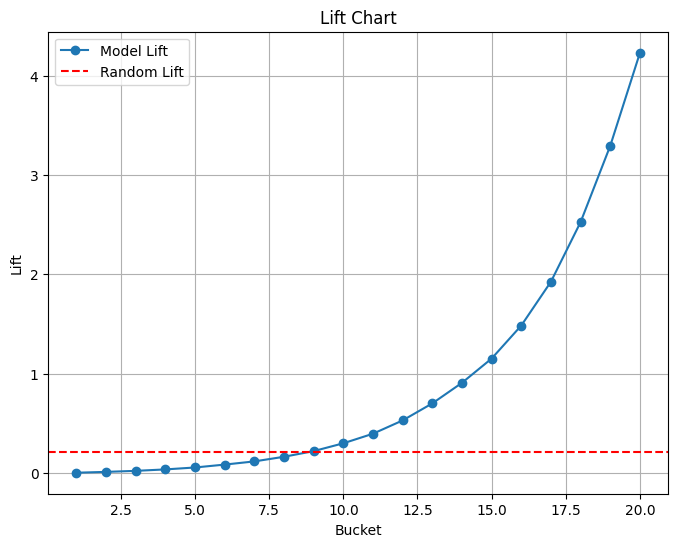

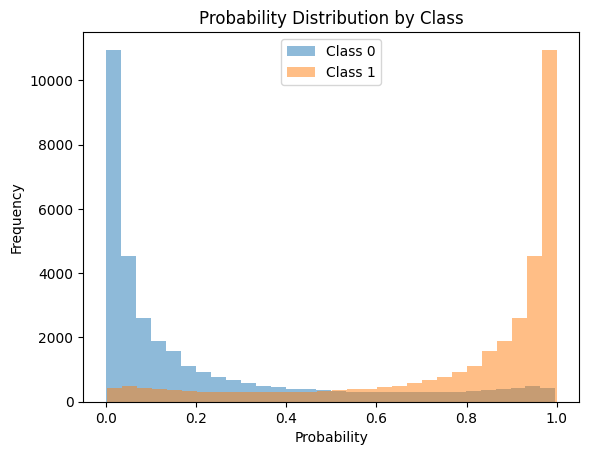

2024-08-25 22:33:13,762 - root - INFO - Start saving out of fold data.
2024-08-25 22:33:13,854 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast_cv.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2024-08-25 22:33:13,854 - root - INFO - Start fitting model number 1 with random seed 433
2024-08-25 22:33:13,855 - root - INFO - BlueCast blueprint initialized.
2024-08-25 22:33:13,855 - root - INFO - Start detecting and casting feature types.
2024-08-25 22:33:13,873 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 22:33:13,874 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 22:33:13,920 - root - INFO - Dropped the following columns as constants only: [].

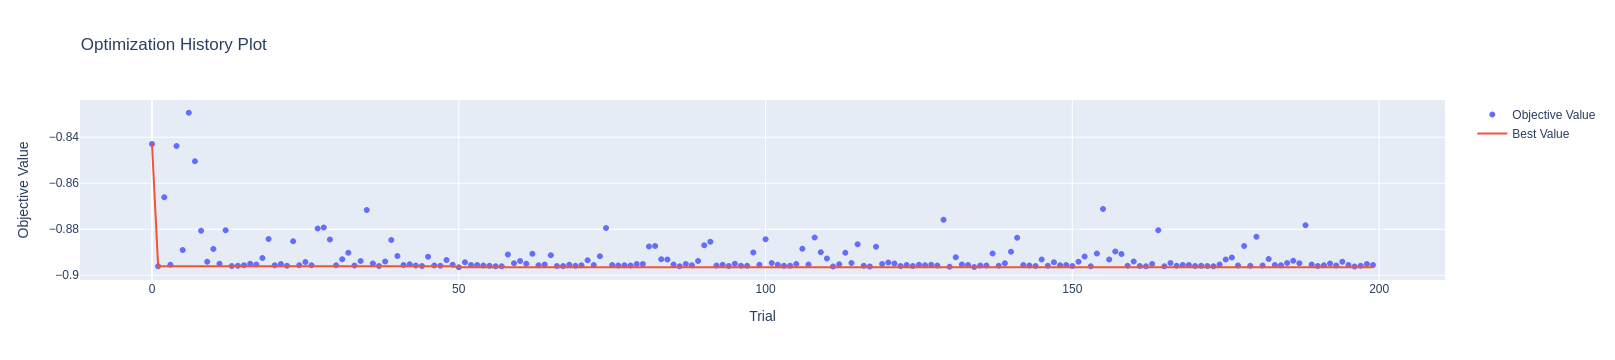

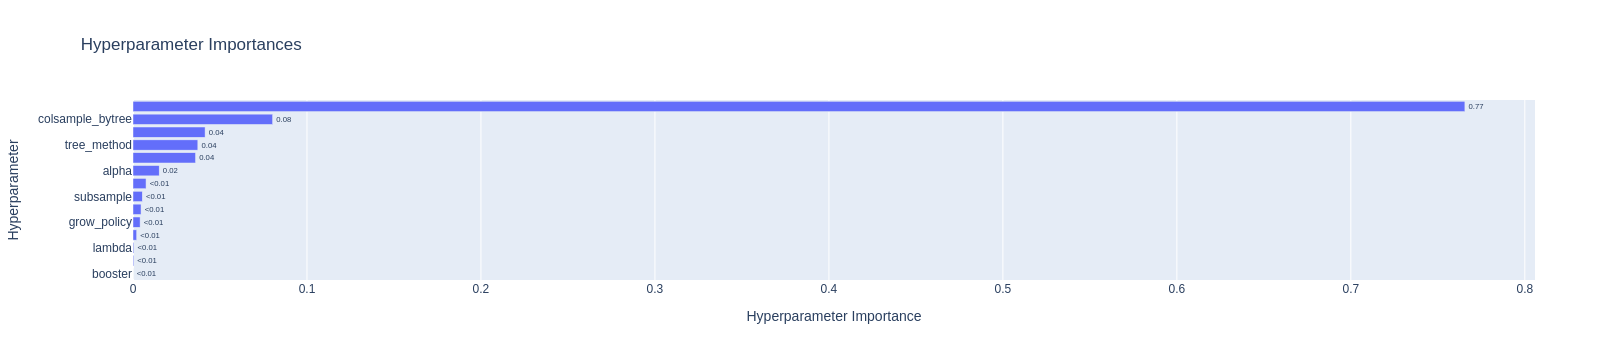

2024-08-25 23:12:46,569 - root - INFO - New best score: -0.8965087925328646 from random seed  433
2024-08-25 23:12:46,570 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 9, 'alpha': 0.00037368341449950767, 'lambda': 3.0749223652954236, 'gamma': 0.002789509419874405, 'min_child_weight': 14.693636744693013, 'subsample': 0.6128784944024014, 'colsample_bytree': 0.6234785801643413, 'colsample_bylevel': 0.6068252096377096, 'eta': 0.018353856136311835, 'steps': 568, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 287}
2024-08-25 23:12:46,571 - root - INFO - Start final model training
2024-08-25 23:12:46,571 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 9, 'alpha': 0.00037368341449950767, 'lambda': 3.0749223652954236, 'gamma': 0.002789509419874405, 'min_child_weight': 14.693636744693013, 'subsample': 0.6128784944024014, 'colsample_bytree': 0.6234785801643413, 'colsample_bylevel': 0.6068252096377096, 'eta': 0.018353856136311835, 'steps': 568, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 287}
Finished hyperparameter tuning


2024-08-25 23:12:55,713 - root - INFO - Finished training


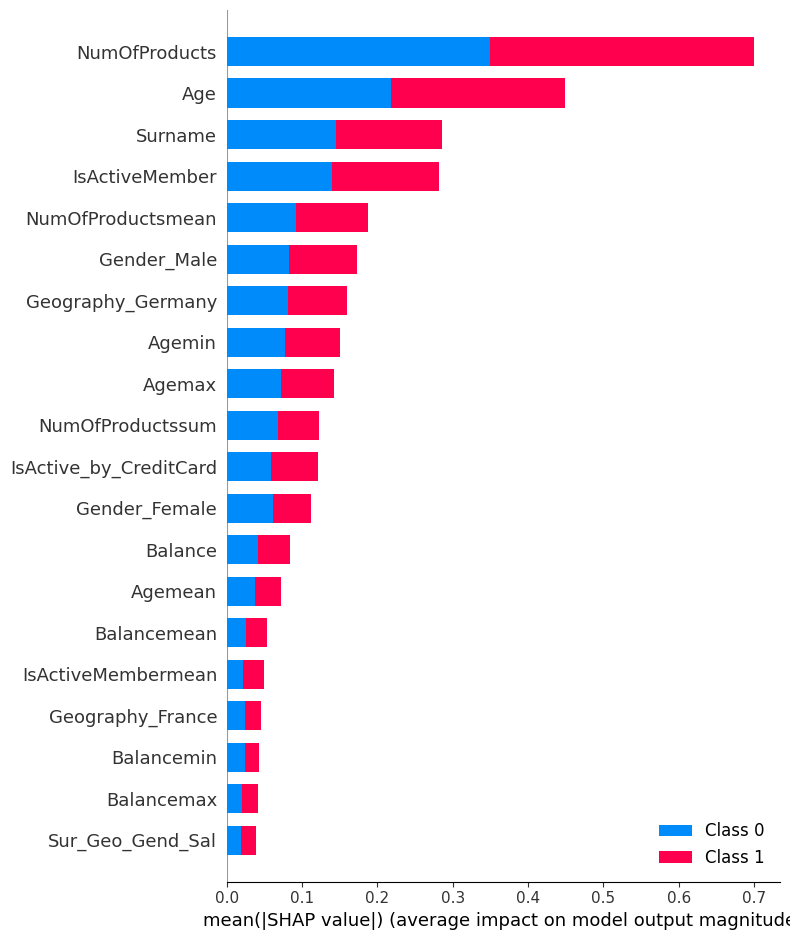

2024-08-25 23:17:21,977 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-25 23:17:21,987 - root - INFO - Start casting feature types.
2024-08-25 23:17:21,989 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:17:21,990 - root - INFO - Dropped the following columns as constants only: [].
2024-08-25 23:17:21,993 - root - INFO - Start filling infinite values.
2024-08-25 23:17:22,010 - root - INFO - Start date column conversion.
2024-08-25 23:17:22,011 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-25 23:17:22,015 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:17:22,039 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:17:22,059 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:17:22,077 - root - INFO - Predicting...
2024-08-25 23:17:22

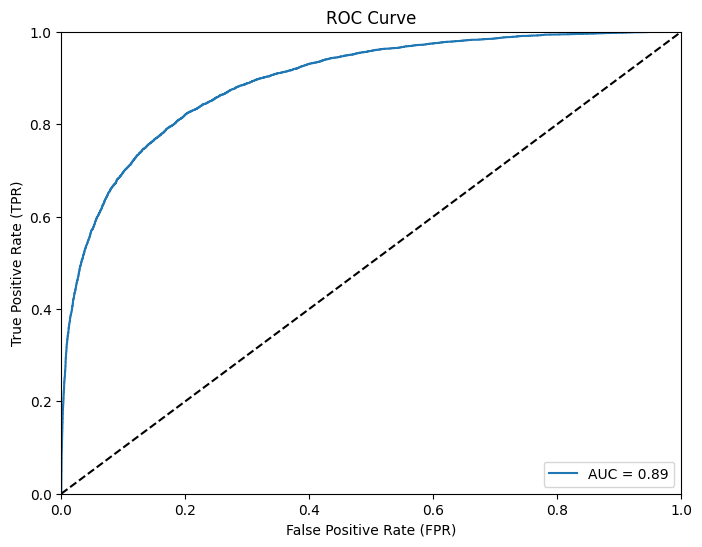

2024-08-25 23:17:22,488 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


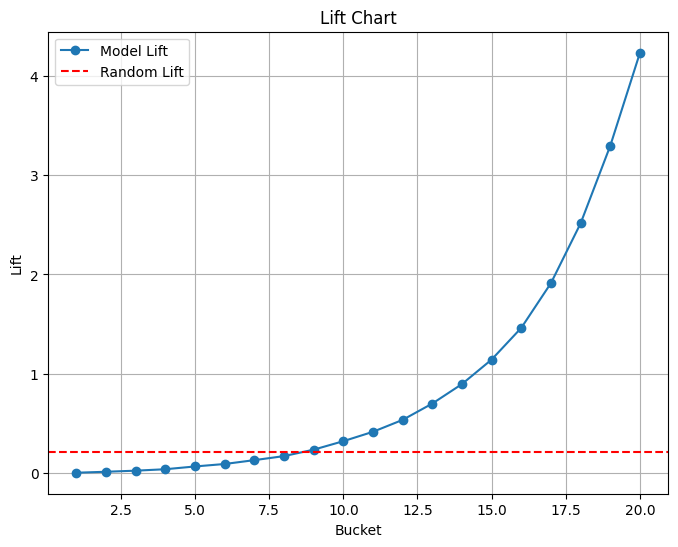

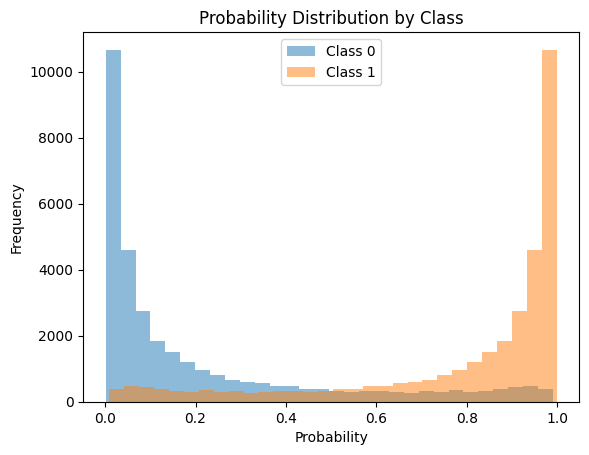

2024-08-25 23:17:22,748 - root - INFO - Start saving out of fold data.
2024-08-25 23:17:22,920 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast_cv.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2024-08-25 23:17:22,921 - root - INFO - Start fitting model number 2 with random seed 633
2024-08-25 23:17:22,921 - root - INFO - BlueCast blueprint initialized.
2024-08-25 23:17:22,921 - root - INFO - Start detecting and casting feature types.
2024-08-25 23:17:22,947 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:17:22,948 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:17:23,026 - root - INFO - Dropped the following columns as constants only: [].

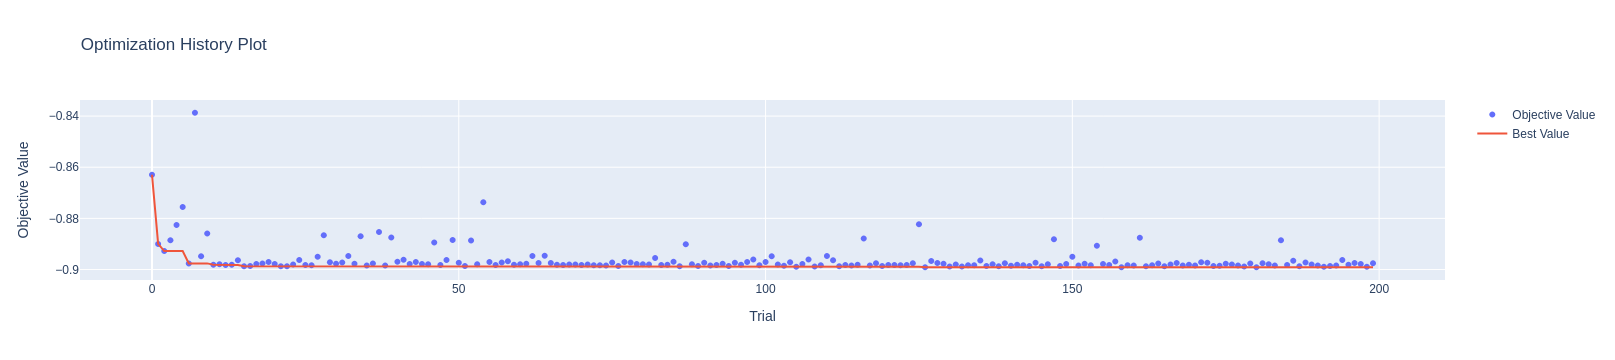

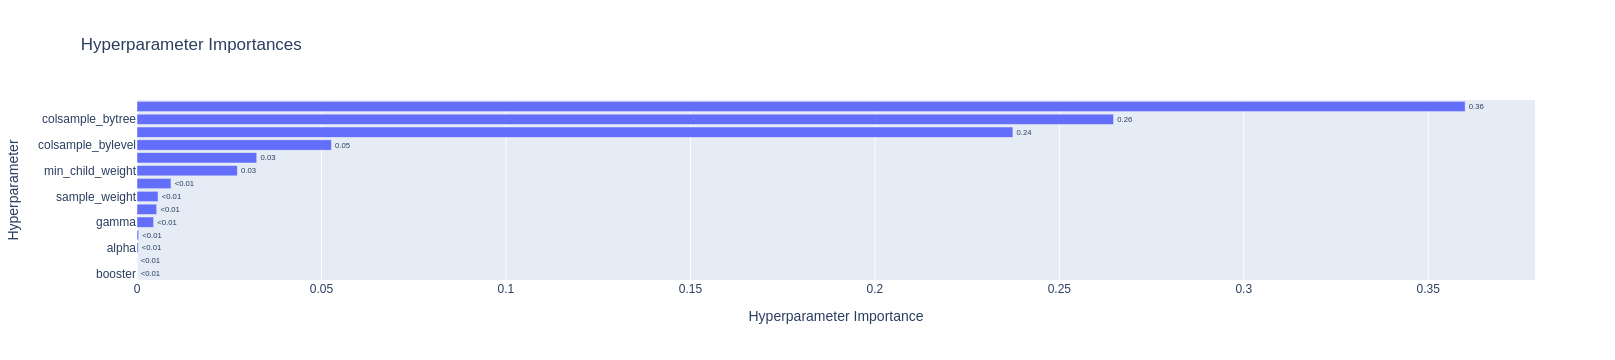

2024-08-25 23:38:31,174 - root - INFO - New best score: -0.8991253095563947 from random seed  633
2024-08-25 23:38:31,175 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 9, 'alpha': 2.145241195987987e-05, 'lambda': 90.9465313593404, 'gamma': 2.0771747748551998e-08, 'min_child_weight': 7.32362074175043, 'subsample': 1.0, 'colsample_bytree': 0.35426391580634475, 'colsample_bylevel': 0.5927371279923733, 'eta': 0.20286632307951621, 'steps': 59, 'tree_method': 'hist', 'grow_policy': 'lossguide', 'max_bin': 130}
2024-08-25 23:38:31,176 - root - INFO - Start final model training
2024-08-25 23:38:31,177 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 9, 'alpha': 2.145241195987987e-05, 'lambda': 90.9465313593404, 'gamma': 2.0771747748551998e-08, 'min_child_weight': 7.32362074175043, 'subsample': 1.0, 'colsample_bytree': 0.35426391580634475, 'colsample_bylevel': 0.5927371279923733, 'eta': 0.20286632307951621, 'steps': 59, 'tree_method': 'hist', 'grow_policy': 'lossguide', 'max_bin': 130}
Finished hyperparameter tuning


2024-08-25 23:38:32,876 - root - INFO - Finished training


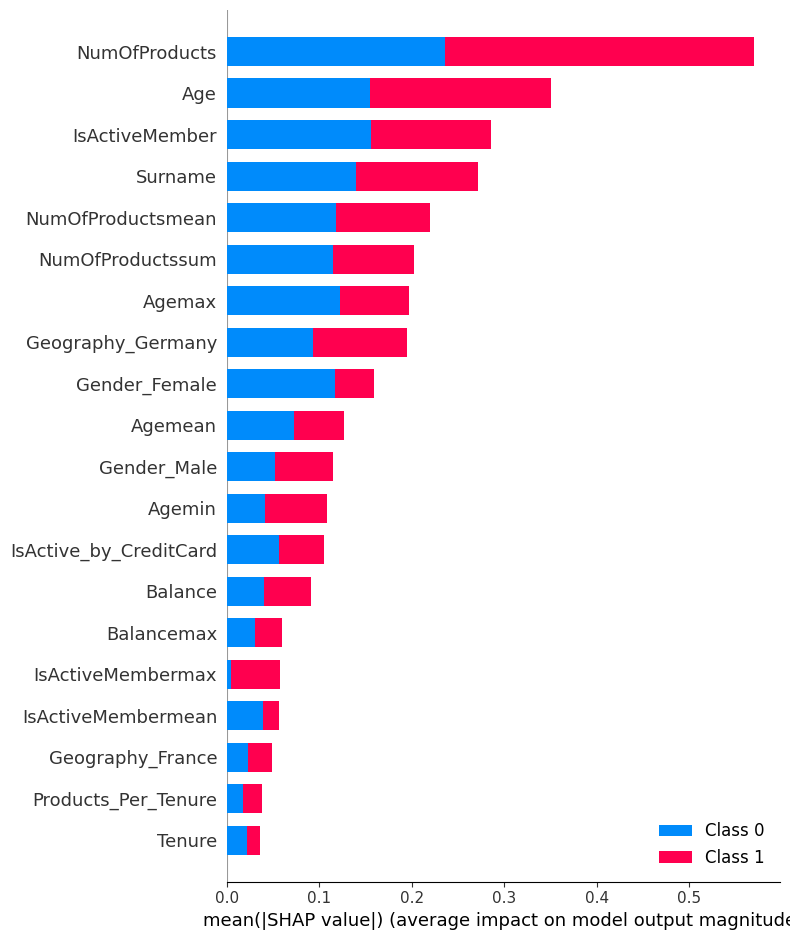

2024-08-25 23:39:03,550 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-25 23:39:03,557 - root - INFO - Start casting feature types.
2024-08-25 23:39:03,558 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:39:03,559 - root - INFO - Dropped the following columns as constants only: [].
2024-08-25 23:39:03,561 - root - INFO - Start filling infinite values.
2024-08-25 23:39:03,572 - root - INFO - Start date column conversion.
2024-08-25 23:39:03,573 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-25 23:39:03,575 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:39:03,588 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:39:03,602 - root - INFO - Start transforming categories with binary target encoder.
2024-08-25 23:39:03,613 - root - INFO - Predicting...
2024-08-25 23:39:03

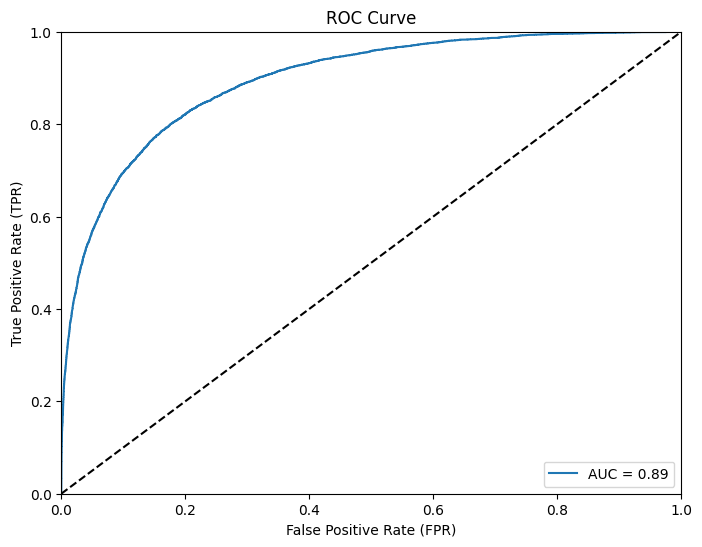

2024-08-25 23:39:03,793 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


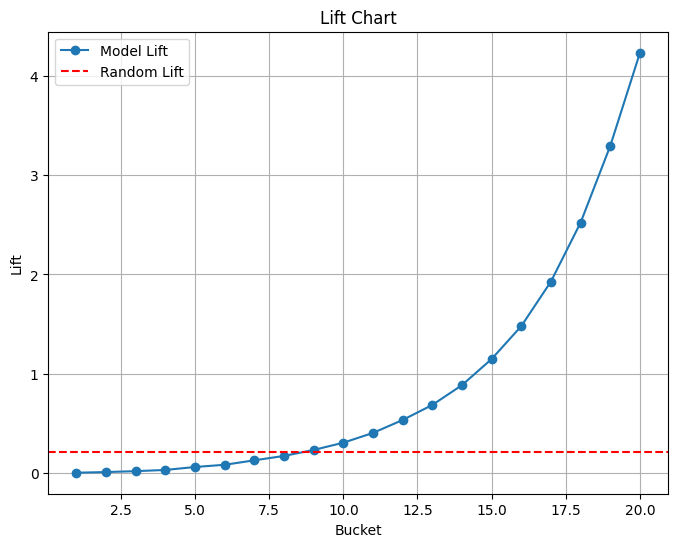

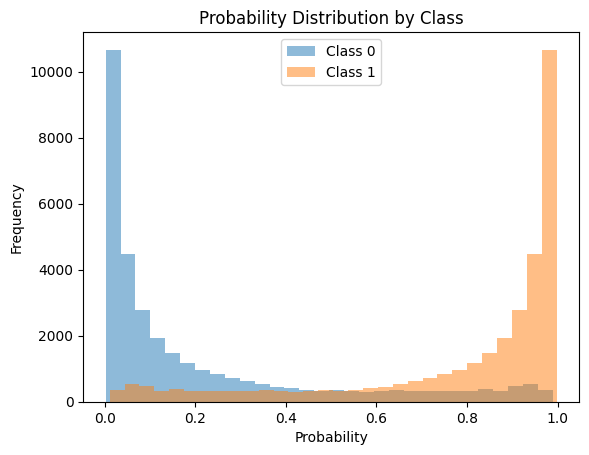

2024-08-25 23:39:03,941 - root - INFO - Start saving out of fold data.
2024-08-25 23:39:04,050 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast_cv.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2024-08-25 23:39:04,050 - root - INFO - Start fitting model number 3 with random seed 833
2024-08-25 23:39:04,051 - root - INFO - BlueCast blueprint initialized.
2024-08-25 23:39:04,051 - root - INFO - Start detecting and casting feature types.
2024-08-25 23:39:04,069 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:39:04,070 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-25 23:39:04,116 - root - INFO - Dropped the following columns as constants only: [].

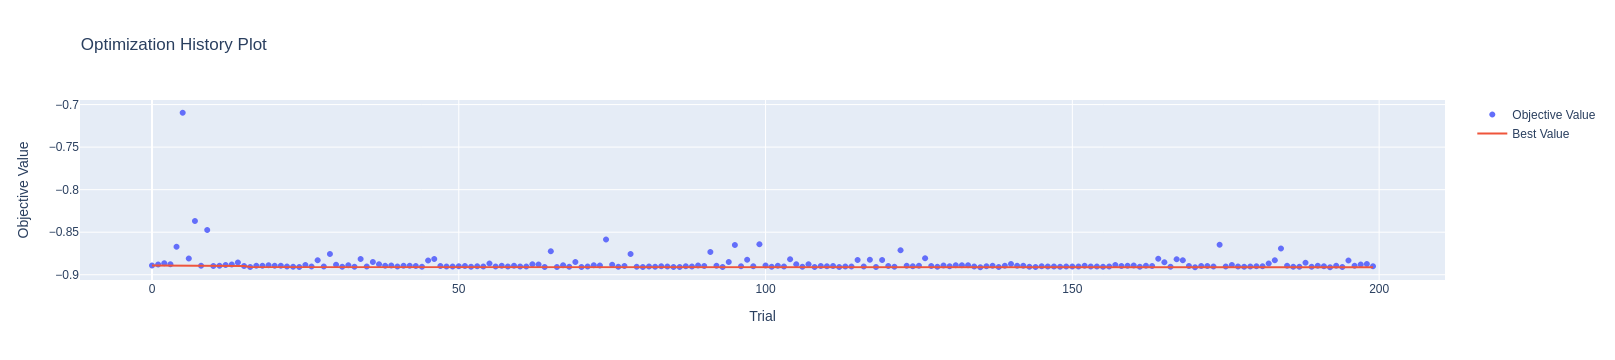

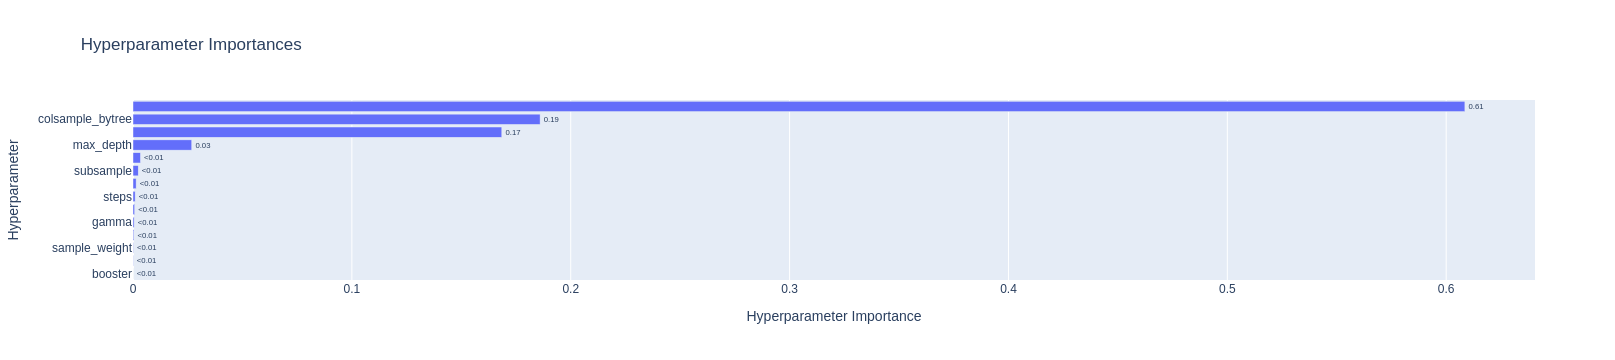

2024-08-26 00:11:32,307 - root - INFO - New best score: -0.8911930290214 from random seed  833
2024-08-26 00:11:32,308 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 7, 'alpha': 79.52840667124246, 'lambda': 52.44028303563648, 'gamma': 3.89616936750893e-08, 'min_child_weight': 11.522860850811536, 'subsample': 0.9666081808206488, 'colsample_bytree': 0.3709924433098458, 'colsample_bylevel': 0.8505923690136189, 'eta': 0.10931296536605563, 'steps': 401, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 799}
2024-08-26 00:11:32,309 - root - INFO - Start final model training
2024-08-26 00:11:32,309 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 7, 'alpha': 79.52840667124246, 'lambda': 52.44028303563648, 'gamma': 3.89616936750893e-08, 'min_child_weight': 11.522860850811536, 'subsample': 0.9666081808206488, 'colsample_bytree': 0.3709924433098458, 'colsample_bylevel': 0.8505923690136189, 'eta': 0.10931296536605563, 'steps': 401, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 799}
Finished hyperparameter tuning


2024-08-26 00:11:54,709 - root - INFO - Finished training


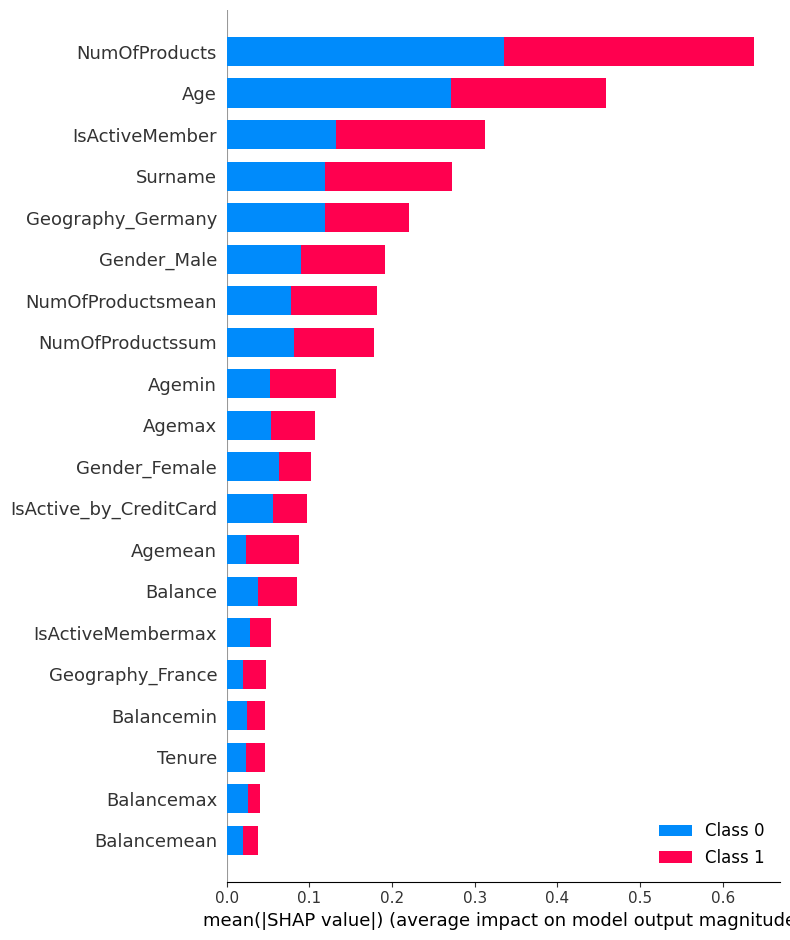

2024-08-26 00:12:07,648 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-26 00:12:07,656 - root - INFO - Start casting feature types.
2024-08-26 00:12:07,657 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-26 00:12:07,658 - root - INFO - Dropped the following columns as constants only: [].
2024-08-26 00:12:07,660 - root - INFO - Start filling infinite values.
2024-08-26 00:12:07,671 - root - INFO - Start date column conversion.
2024-08-26 00:12:07,672 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-26 00:12:07,675 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:12:07,690 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:12:07,704 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:12:07,715 - root - INFO - Predicting...
2024-08-26 00:12:07

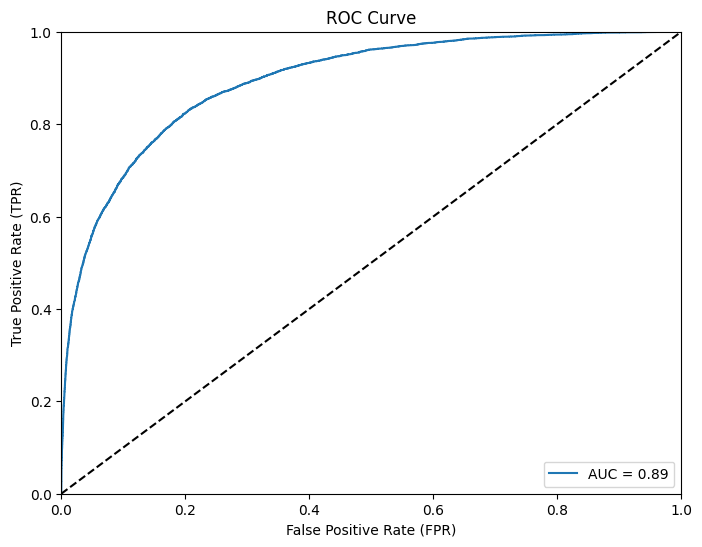

2024-08-26 00:12:07,930 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


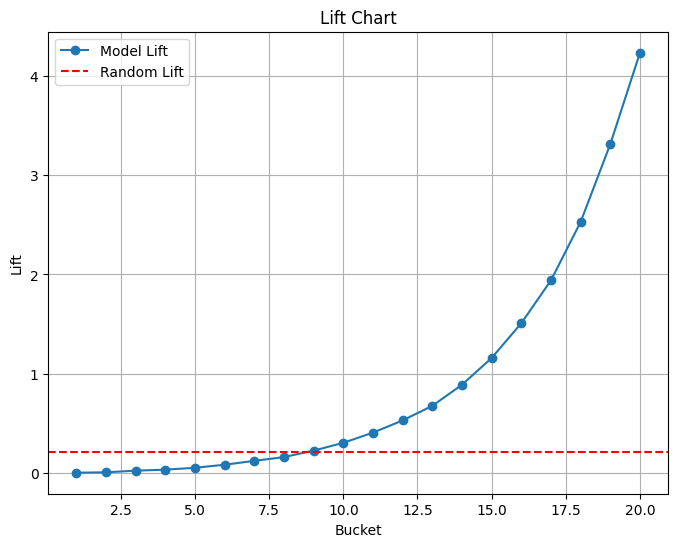

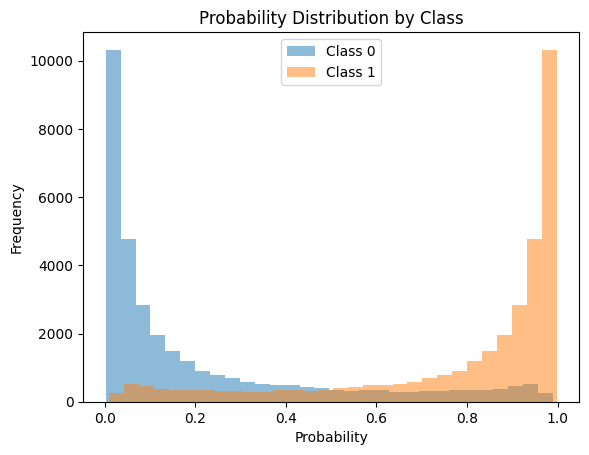

2024-08-26 00:12:08,077 - root - INFO - Start saving out of fold data.
2024-08-26 00:12:08,186 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/blueprints/cast_cv.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2024-08-26 00:12:08,186 - root - INFO - Start fitting model number 4 with random seed 1033
2024-08-26 00:12:08,187 - root - INFO - BlueCast blueprint initialized.
2024-08-26 00:12:08,187 - root - INFO - Start detecting and casting feature types.
2024-08-26 00:12:08,203 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-26 00:12:08,203 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-26 00:12:08,249 - root - INFO - Dropped the following columns as constants only: []

2024-08-26 00:36:51,521 - root - INFO - New best score: -0.8984068079403507 from random seed  1033
2024-08-26 00:36:51,523 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 5, 'alpha': 1.1101450409334488e-08, 'lambda': 28.14944714291193, 'gamma': 0.00011514712358672537, 'min_child_weight': 6.954998969800464, 'subsample': 1.0, 'colsample_bytree': 0.5106062936508482, 'colsample_bylevel': 0.547423610928444, 'eta': 0.15935326368576355, 'steps': 311, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 132}
2024-08-26 00:36:51,524 - root - INFO - Start final model training
2024-08-26 00:36:51,524 - root - INFO - Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'auc', 'num_class': 2, 'max_depth': 5, 'alpha': 1.1101450409334488e-08, 'lambda': 28.14944714291193, 'gamma': 0.00011514712358672537, 'min_child_weight': 6.954998969800464, 'subsample': 1.0, 'colsample_bytree': 0.5106062936508482, 'colsample_bylevel': 0.547423610928444, 'eta': 0.15935326368576355, 'steps': 311, 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 132}
Finished hyperparameter tuning


2024-08-26 00:37:06,749 - root - INFO - Finished training


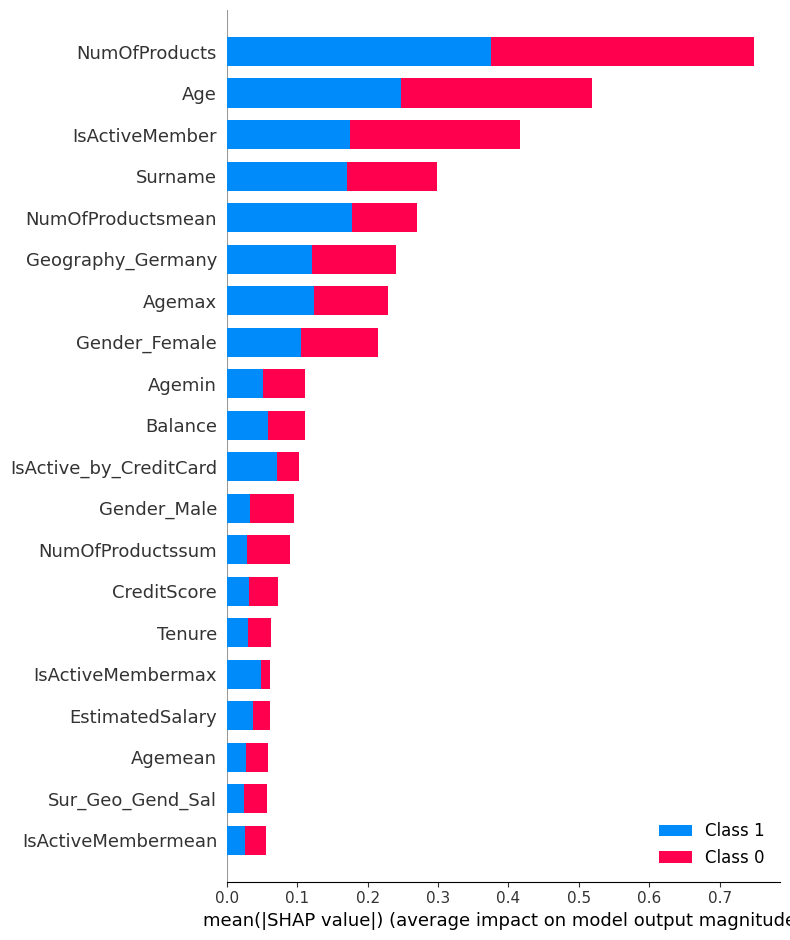

2024-08-26 00:37:19,279 - root - INFO - Plotting interactions of most important features by global SHAP values...
2024-08-26 00:37:19,288 - root - INFO - Start casting feature types.
2024-08-26 00:37:19,290 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-26 00:37:19,291 - root - INFO - Dropped the following columns as constants only: [].
2024-08-26 00:37:19,294 - root - INFO - Start filling infinite values.
2024-08-26 00:37:19,311 - root - INFO - Start date column conversion.
2024-08-26 00:37:19,312 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-26 00:37:19,316 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:19,339 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:19,359 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:19,377 - root - INFO - Predicting...
2024-08-26 00:37:19

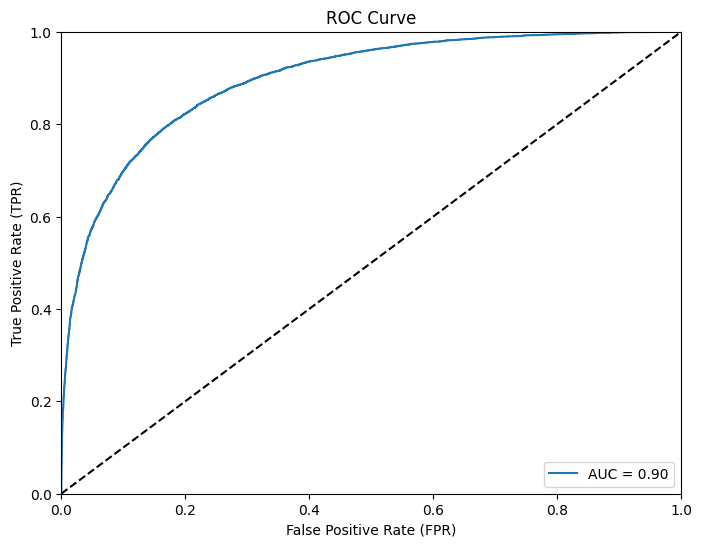

2024-08-26 00:37:19,704 - root - WARNING - /home/thomas/IdeaProjects/BlueCast/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


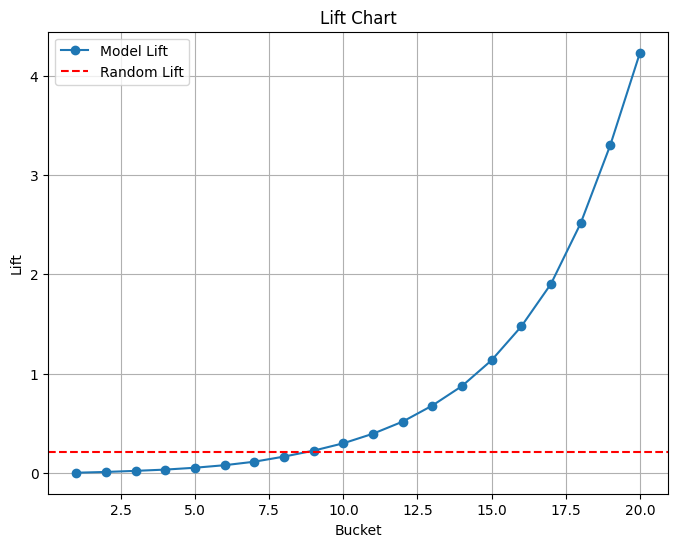

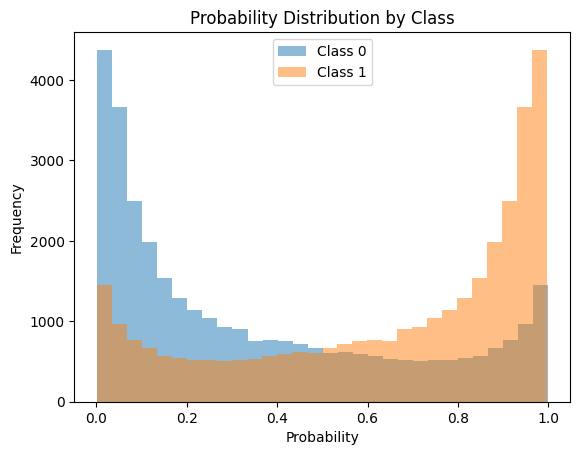

2024-08-26 00:37:19,962 - root - INFO - Start saving out of fold data.
2024-08-26 00:37:20,129 - root - INFO - The mean out of fold matthews score is 0.5715839521933813 with an std of 0.008362819334468922


(0.5715839521933813, 0.008362819334468922)

In [10]:
automl_baseline.fit_eval(
    df=train,
    target_col=TARGET,
)

In [11]:
y_probs, y_classes = automl_baseline.predict(test)

2024-08-26 00:37:20,144 - root - INFO - Start casting feature types.
2024-08-26 00:37:20,154 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-08-26 00:37:20,154 - root - INFO - Dropped the following columns as constants only: [].
2024-08-26 00:37:20,161 - root - INFO - Start filling infinite values.
2024-08-26 00:37:20,213 - root - INFO - Start date column conversion.
2024-08-26 00:37:20,214 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-08-26 00:37:20,226 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:20,277 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:20,327 - root - INFO - Start transforming categories with binary target encoder.
2024-08-26 00:37:20,372 - root - INFO - Predicting...
2024-08-26 00:37:20,373 - root - INFO - Start predicting on new data using Xgboost model.
2024-08-26 00:37:20,956 - root - INFO - Fin

In [12]:
submission[TARGET] = y_probs
submission.to_csv("automl_bluecastcv_pipeline.csv", index=False)
submission

id    Exited
0       165034  0.026595
1       165035  0.891009
2       165036  0.016234
3       165037  0.229034
4       165038  0.441214
...        ...       ...
110018  275052  0.029712
110019  275053  0.246377
110020  275054  0.026464
110021  275055  0.233151
110022  275056  0.168988

[110023 rows x 2 columns]

# Summary

Here the oof scores cannot be compared to the previous notebook as we added deduplication to the eval dataset. This we cannot access from ´BlueCastCV´.

# What would have happened afterwards?

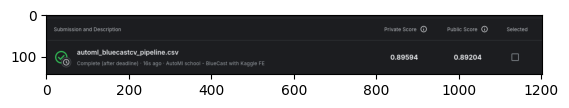

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('automl_bluecastcv_with_fe_kaggle.png')
imgplot = plt.imshow(img)
plt.show()

That would have been rank 419 out of 3633 with a single model and not using all data! We have built this within little time while participants in the competition had a full month.